## Evaluating scores and predictions from the following methods:
### - gmm
### - similarity
### - todo...

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('bmh')
os.chdir('/home/seidi/Repositories/prox_graph_auto_config')

# Score evaluation

In [2]:
path = 'src/notebooks/2020.11.30/results/scores'
score_files = [os.path.join(path, f) for f in os.listdir(path) if os.path.isfile(os.path.join(path,f))]
scores = pd.DataFrame()
for sf in score_files:
    df = pd.read_csv(sf)
    file_name = sf.split('/')[-1].split('.')[0]
    if 'target' in df.columns:
        df = df[df.target == 'Recall']
    if 'mse' in df.columns:
        df.mse = df.mse ** (1/2)
        df = df.rename(columns={'mse': 'rmse'})
    
    df = df.rename(columns={'approach': 'method'})

    if file_name.startswith('clus'):
        df['details'] = 'eps=' + df.eps.astype(float).round(2).astype(str)
    else:
        df['details'] = np.nan
    df['method'] = file_name
    
    df['base'] = df['base'].apply(lambda x: x.split('_')[0])

    df = df[['base', 'method', 'r2', 'rmse', 'details']]
    scores = pd.concat([scores, df])

scores

,base,method,r2,rmse,details
0,sift,gmm_scores_original,0.701179,0.207703,NaN
4,mnist,gmm_scores_original,0.953814,0.060402,NaN
8,colorHisto,gmm_scores_original,0.804167,0.091669,NaN
12,moments,gmm_scores_original,0.980011,0.027494,NaN
16,texture,gmm_scores_original,0.977051,0.030126,NaN
...,...,...,...,...,...
2,moments,similarity_mb=int_k=5,0.975035,0.027382,NaN
3,mnist121d,similarity_mb=int_k=5,0.990468,0.022883,NaN
4,fashion,similarity_mb=int_k=5,0.846797,0.097394,NaN
5,colorHisto,similarity_mb=int_k=5,0.990686,0.017495,NaN


## Similarity
### - `k=[1,3,5]` most similar dataset(s)
### - `metabase=[original, interpoalted]`
### - `f=5` most relavant features for measuring similarity

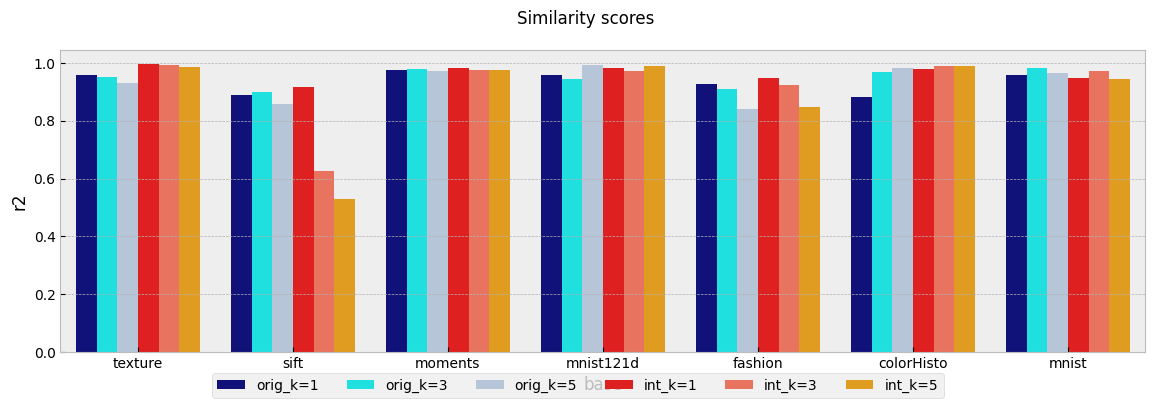

In [4]:
PALETTE = {
    "orig_k=1": "darkblue",
    "orig_k=3": "aqua",
    "orig_k=5": "lightsteelblue",
    "int_k=1": "red",
    "int_k=3": "tomato",
    "int_k=5": "orange",
}

HUE_ORDER = ["orig_k=1","orig_k=3","orig_k=5","int_k=1","int_k=3","int_k=5"]

tmp = scores[scores.method.str.startswith('simil')].copy()
tmp.method = tmp.method.str.replace('similarity_mb=', '')

fig, ax = plt.subplots(1,1,figsize=(14, 4), dpi=100)
sns.barplot(x='base', y='r2', hue='method', data=tmp, ax=ax, palette=PALETTE, hue_order=HUE_ORDER)
ax.get_legend().remove()

plt.suptitle('Similarity scores')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=6)#, bbox_to_anchor=(0.75, 0.53))

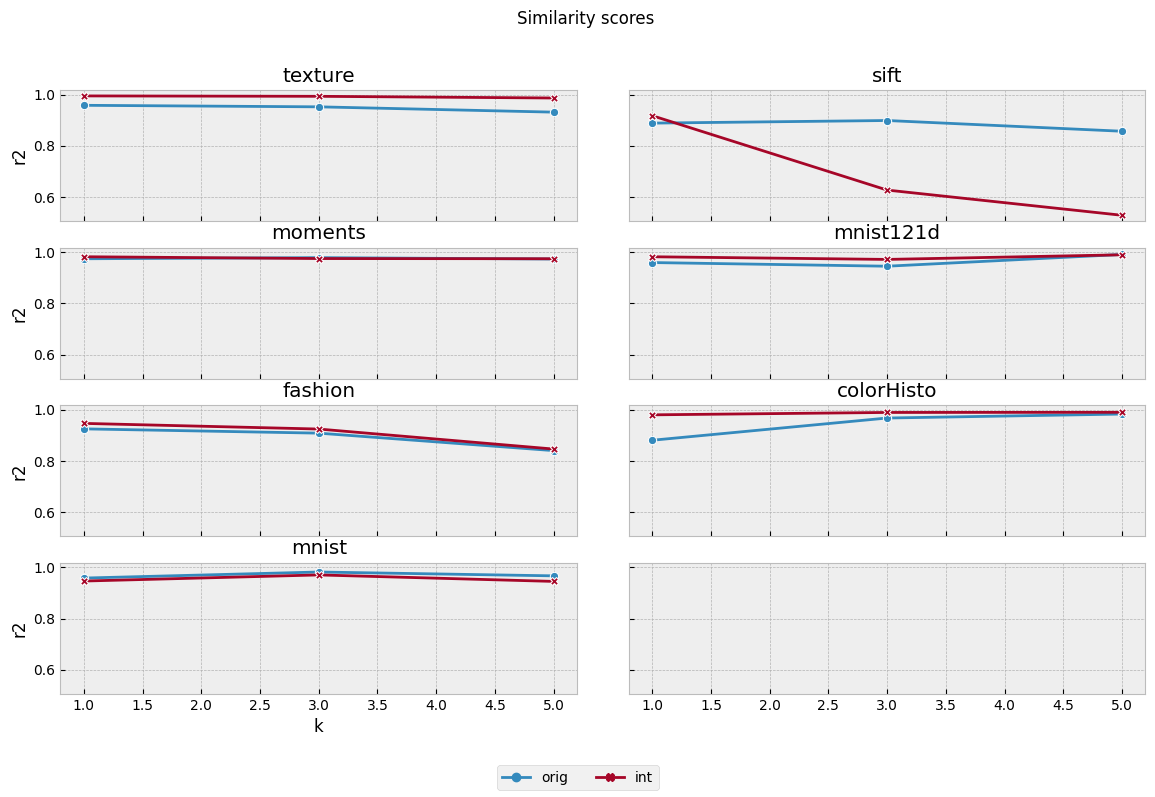

In [7]:
fig, axes = plt.subplots(4, 2, figsize=(14, 8), dpi=100, sharex=True, sharey=True)
axes = iter(axes.reshape(-1))

tmp.loc[:, 'metabase'] = tmp.method.apply(lambda x: x.split('_')[0])
tmp.loc[:, 'k'] = tmp.method.apply(lambda x: x.split('=')[-1]).astype(int)
for b in tmp.base.unique():
    ax = next(axes)
    sns.lineplot(x='k', y='r2', hue='metabase', data=tmp[tmp.base==b], ax=ax, markers=True, style='metabase', dashes=False)
    ax.set_title(b)
    ax.get_legend().remove()

plt.suptitle('Similarity scores')
plt.subplots_adjust(wspace=0.1)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2)

In [34]:
print('\t--- Avaliando o melhor k ---')
tmp.groupby(['method']).r2.describe()[['mean', 'std', 'min', 'max']]

	--- Avaliando o melhor k ---


,mean,std,min,max
method,,,,
int_k=1,0.964938,0.027837,0.918242,0.995646
int_k=3,0.922196,0.132105,0.626965,0.994078
int_k=5,0.894880,0.169623,0.528212,0.990686
orig_k=1,0.935536,0.037481,0.881277,0.974953
orig_k=3,0.948153,0.032867,0.899347,0.982303
orig_k=5,0.935292,0.062062,0.840709,0.991851


## Clustering
### - `eps=[1,...,3]` for weighted similarity, and `eps=[4,...6]` for raw similarity
### - original and interpolated metabase

#### fix: script errado rodou apenas um eps, refazendo experimentos...

<AxesSubplot:xlabel='base', ylabel='r2'>

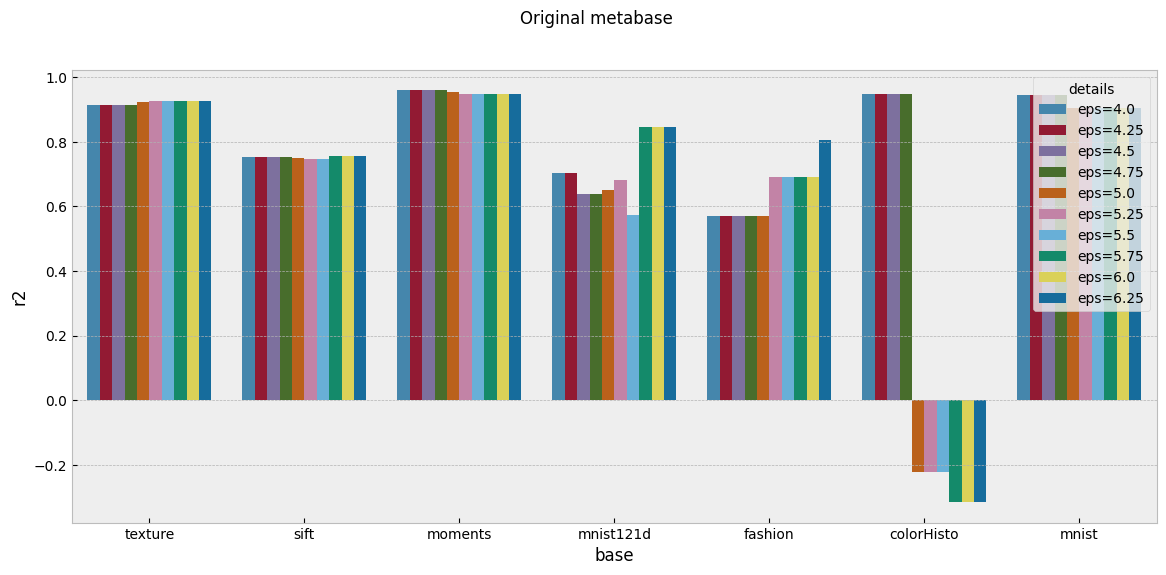

In [7]:
tmp = scores[scores.method.str.endswith('clustering')].copy()
plt.figure(figsize=(14,6), dpi=100)
plt.suptitle('Original metabase')
sns.barplot(x='base', y='r2', hue='details', data=tmp)

<AxesSubplot:xlabel='base', ylabel='r2'>

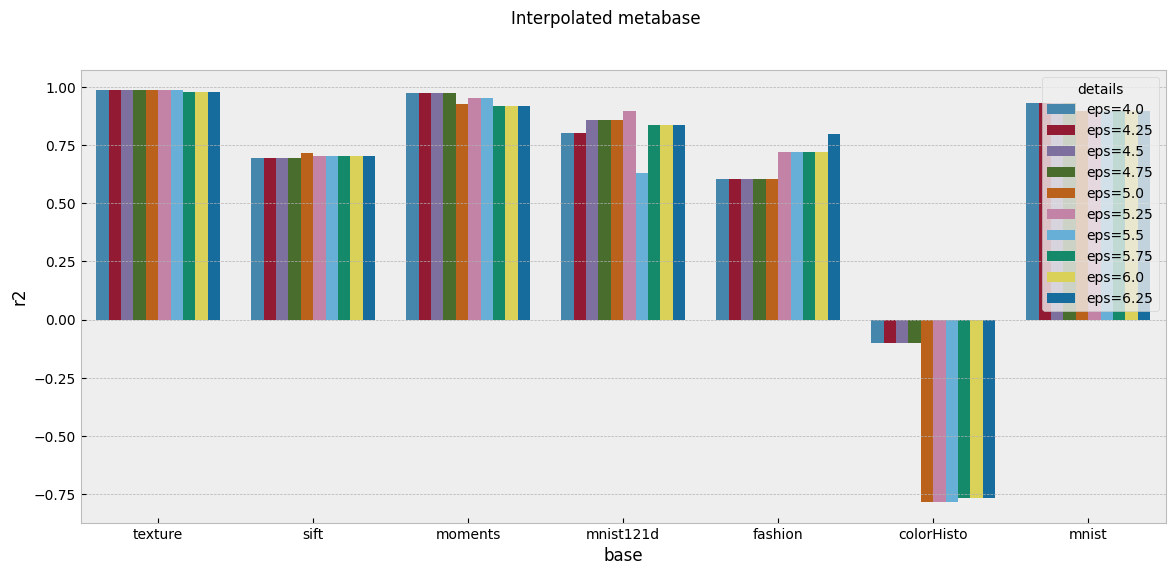

In [8]:
tmp = scores[scores.method.str.endswith('clustering_inter')].copy()
plt.figure(figsize=(14,6), dpi=100)
plt.suptitle('Interpolated metabase')
sns.barplot(x='base', y='r2', hue='details', data=tmp)

In [22]:
tmp = scores[scores.method.str.startswith('clus')].copy()
print('\t--- Médias e STD das performances de acordo com cada metabase ---')
print('mean r2\n', tmp.groupby('method').r2.describe()[['mean', 'std', 'min', 'max']])

	--- Médias e STD das performances de acordo com cada metabase ---
mean r2
                       mean       std       min       max
method                                                  
clustering        0.731203  0.332968 -0.315340  0.959653
clustering_inter  0.646398  0.503966 -0.783459  0.985075


In [24]:
print('\t--- Selecionando melhor eps ---')
tmp = scores[scores.method.str.endswith('clustering')].copy()
tmp.groupby('details').r2.describe()[['mean', 'std', 'min', 'max']].head()

	--- Selecionando melhor eps ---


,mean,std,min,max
details,,,,
eps=4.0,0.827388,0.152608,0.570056,0.959653
eps=4.25,0.827388,0.152608,0.570056,0.959653
eps=4.5,0.818038,0.163085,0.570056,0.959653
eps=4.75,0.818038,0.163085,0.570056,0.959653
eps=5.0,0.646384,0.409595,-0.222047,0.953710


## Overall

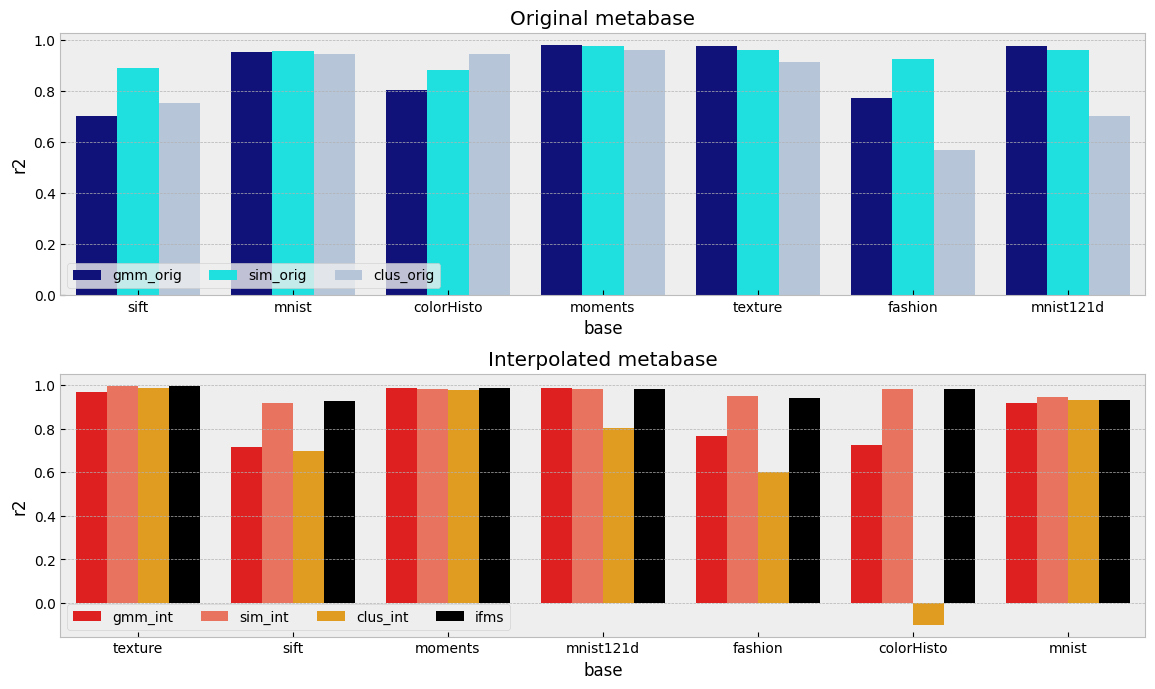

In [111]:
PALETTE = {
    "gmm_orig": "darkblue",
    "sim_orig": "aqua",
    "clus_orig": "lightsteelblue",
    "gmm_int": "red",
    "sim_int": "tomato",
    "clus_int": "orange",
    "ifms": "black"
}

HUE_ORDER_ORIG = ["gmm_orig","sim_orig","clus_orig"]
HUE_ORDER_INT = ["gmm_int","sim_int","clus_int","ifms"]


tmp = scores.copy()
tmp = tmp[(tmp.details == 'eps=4.0') | (tmp.details.isna())]
tmp = tmp[~tmp.method.str.endswith('k=3')]
tmp = tmp[~tmp.method.str.endswith('k=5')]

tmp.method = tmp.method.replace({
    'gmm_scores_original': 'gmm_orig',
    'gmm_scores_interpolated_v1': 'gmm_int',
    'similarity_mb=orig_k=1': 'sim_orig',
    'similarity_mb=int_k=1': 'sim_int',
    'clustering': 'clus_orig',
    'clustering_inter': 'clus_int'
})

fig, axes = plt.subplots(2,1,figsize=(14,8),dpi=100)
sns.barplot(x='base', y='r2', hue='method', data=tmp[tmp.method.str.endswith('orig')], ax=axes[0], palette=PALETTE, hue_order=HUE_ORDER_ORIG)
axes[0].set_title('Original metabase')
axes[0].legend(ncol=4, loc='lower left')

sns.barplot(x='base', y='r2', hue='method', data=tmp[~tmp.method.str.endswith('orig')], ax=axes[1], palette=PALETTE, hue_order=HUE_ORDER_INT)
axes[1].set_title('Interpolated metabase')
axes[1].legend(ncol=4, loc='lower left')

plt.subplots_adjust(hspace=0.3)

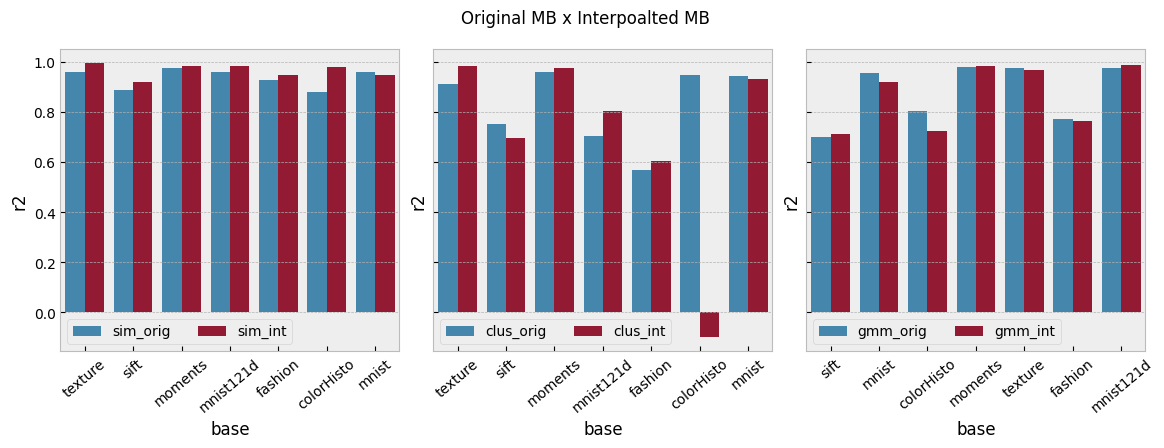

In [139]:
fig, axes = plt.subplots(1,3,figsize=(14,4),dpi=100, sharey=True)
axes = iter(axes.reshape(-1))
methods = tmp.method.unique()
methods = set(m for m in map(lambda x: x.split('_')[0], methods) if m != 'ifms')

plt.suptitle('Original MB x Interpoalted MB')
for m in methods:
    m = m.split('_')[0]
    if m == 'ifms':
        continue

    hue_order = [m + '_orig', m + '_int']
    ax = next(axes)
    g = sns.barplot(x='base', y='r2', hue='method', data=tmp[tmp.method.str.startswith(m)], ax=ax, hue_order=hue_order)
    ax.set_xticklabels(g.get_xticklabels(), rotation=40)
    ax.legend(loc='lower left', ncol=2)
    plt.subplots_adjust(wspace=.1)



<AxesSubplot:xlabel='method', ylabel='r2'>

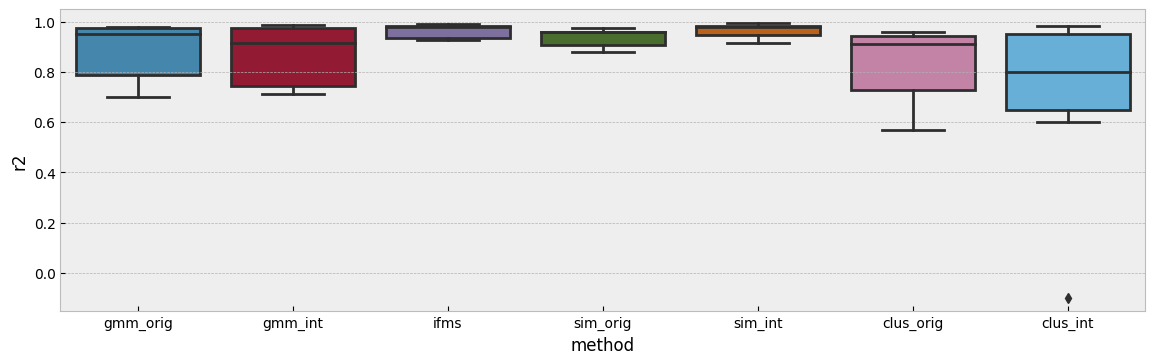

In [158]:
ORDER = ["gmm_orig", "gmm_int","ifms","sim_orig","sim_int","clus_orig","clus_int"]

plt.figure(figsize=(14, 4), dpi=100)
# plt.axes(ylim=(.5, 1))

sns.boxplot(x='method', y='r2', data=tmp, order=ORDER)

# Prediction quality and Recommendations
## Simiarltiy approaches with k=1
## Ignoring clustering approach

In [14]:
path = 'src/notebooks/2020.11.30/results/predictions'
score_files = [os.path.join(path, f) for f in os.listdir(path) if os.path.isfile(os.path.join(path,f))]
predictions = pd.DataFrame()
for sf in score_files:
    df = pd.read_csv(sf)
    file_name = sf.split('/')[-1].split('.')[0]
    df = df.rename(columns={
        'approach': 'method',
        'IndexParams': 'NN',
        'QueryTimeParams': 'R',
        'true': 'y_true',
        'pred': 'y_pred',
        
        })
    df['method'] = file_name
    predictions = pd.concat([predictions, df])

predictions.drop('nr_inst', axis=1, inplace=True)
predictions.k_searching.fillna(30, inplace=True)
predictions = predictions[predictions.k_searching == 30]
predictions = predictions[predictions.target == 'Recall']
predictions.base = predictions.base.apply(lambda x: x.split('_')[0])
predictions = predictions[predictions.base != 'moments']

predictions.method = predictions.method.apply(lambda x: 'sim_int' if x == 'similarity_mb=int_k=1' else x)
predictions.method = predictions.method.apply(lambda x: 'sim_orig' if x == 'similarity_mb=orig_k=1' else x)
predictions.method = predictions.method.apply(lambda x: 'int' if x == 'ifms' else x)
predictions.method = predictions.method.apply(lambda x: 'gmm_orig' if x == 'gmm' else x)
predictions.method.value_counts()

int         7560
sim_int     7560
gmm_int     7560
gmm_orig    1427
sim_orig    1427
Name: method, dtype: int64

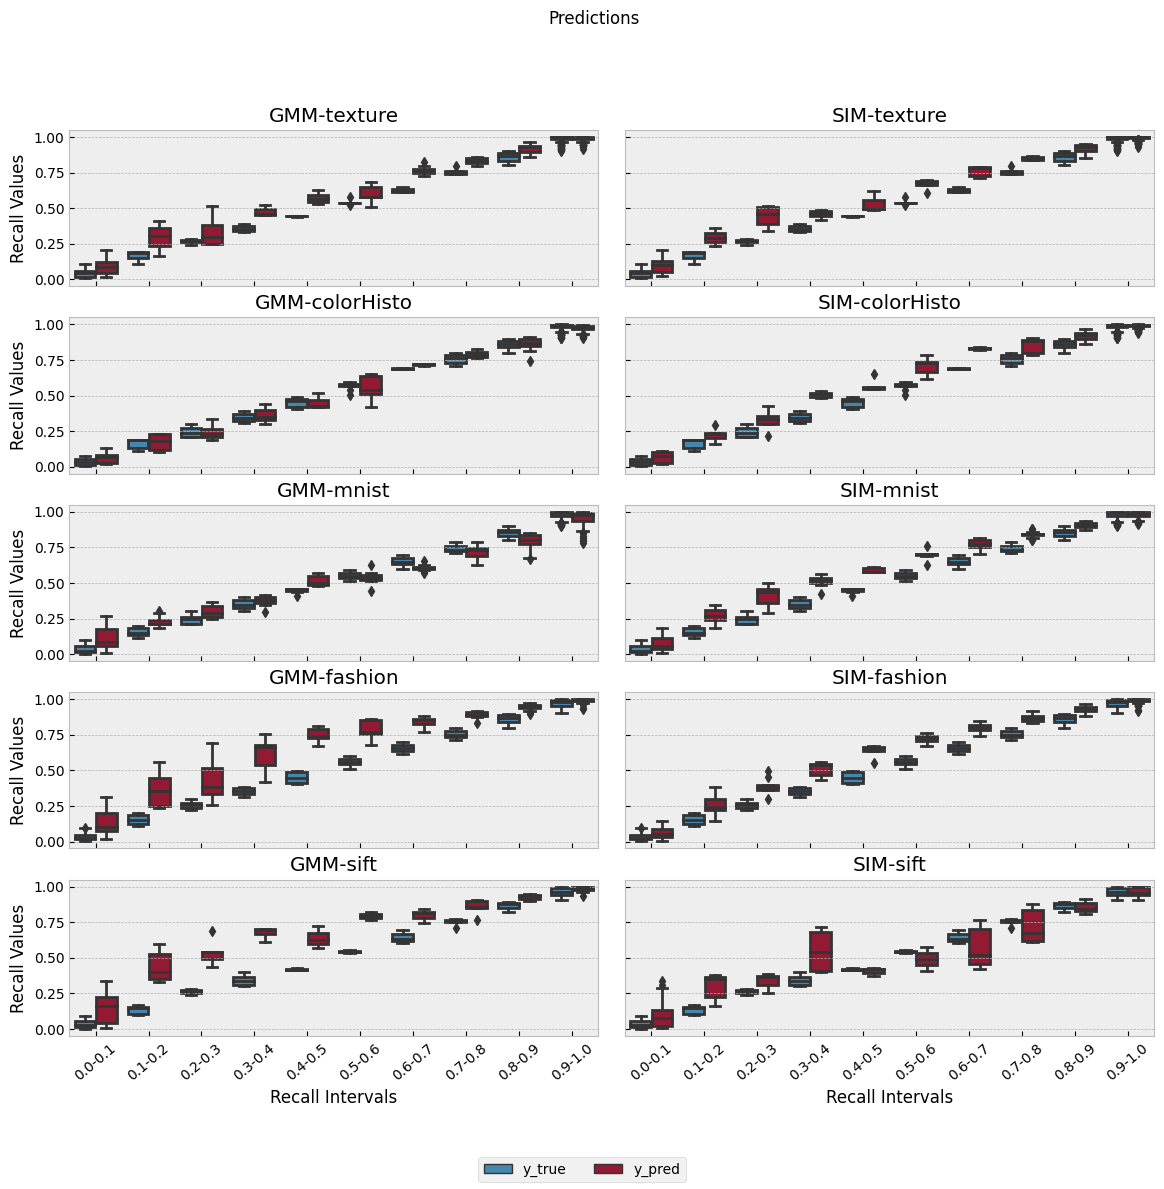

In [48]:
tmp_ = predictions[predictions.method.str.endswith('orig')].copy()

fig, axes = plt.subplots(5,2,figsize=(14,12), dpi=100, sharey=True, sharex=True)
axes = iter(axes.reshape(-1))

l_gambeta = []
for b in ['texture', 'colorHisto', 'mnist', 'fashion', 'sift']:
    ''' gmm '''
    tmp = tmp_[(tmp_.base==b) & (tmp_.method=='gmm_orig')].copy()
    labels = ['{}-{}'.format(np.round(i,1), np.round(i+0.1,1)) for i in np.arange(0,1,0.1)]
    tmp['Recall'] = pd.cut(tmp.y_true, bins=10, labels=labels)
    out = tmp.melt(id_vars='Recall', value_vars=['y_true', 'y_pred'])

    ax = next(axes)
    l_gambeta.append(ax)
    g = sns.boxplot(x='Recall', y='value', hue='variable', data=out, ax=ax)
    ax.set_title(f'GMM-{b}')
    ax.get_legend().remove()
    ax.set_xticklabels(g.get_xticklabels(), rotation=40)

    ''' similarity '''
    tmp = tmp_[(tmp_.base==b) & (tmp_.method=='sim_orig')].copy()
    labels = ['{}-{}'.format(np.round(i,1), np.round(i+0.1,1)) for i in np.arange(0,1,0.1)]
    tmp['Recall'] = pd.cut(tmp.y_true, bins=10, labels=labels)
    out = tmp.melt(id_vars='Recall', value_vars=['y_true', 'y_pred'])

    ax = next(axes)
    l_gambeta.append(ax)
    g = sns.boxplot(x='Recall', y='value', hue='variable', data=out, ax=ax)
    ax.set_title(f'SIM-{b}')
    ax.get_legend().remove()
    ax.set_xticklabels(g.get_xticklabels(), rotation=40)


l_gambeta = np.array(l_gambeta).reshape(5,2)
plt.setp(l_gambeta[-1, :], xlabel='Recall Intervals')
plt.setp(l_gambeta[:, 0], ylabel='Recall Values')
plt.setp(l_gambeta[:-1, :], xlabel='')
plt.setp(l_gambeta[:, 1:], ylabel='')

plt.suptitle('Predictions')
plt.subplots_adjust(wspace=0.05, hspace=0.2)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2)

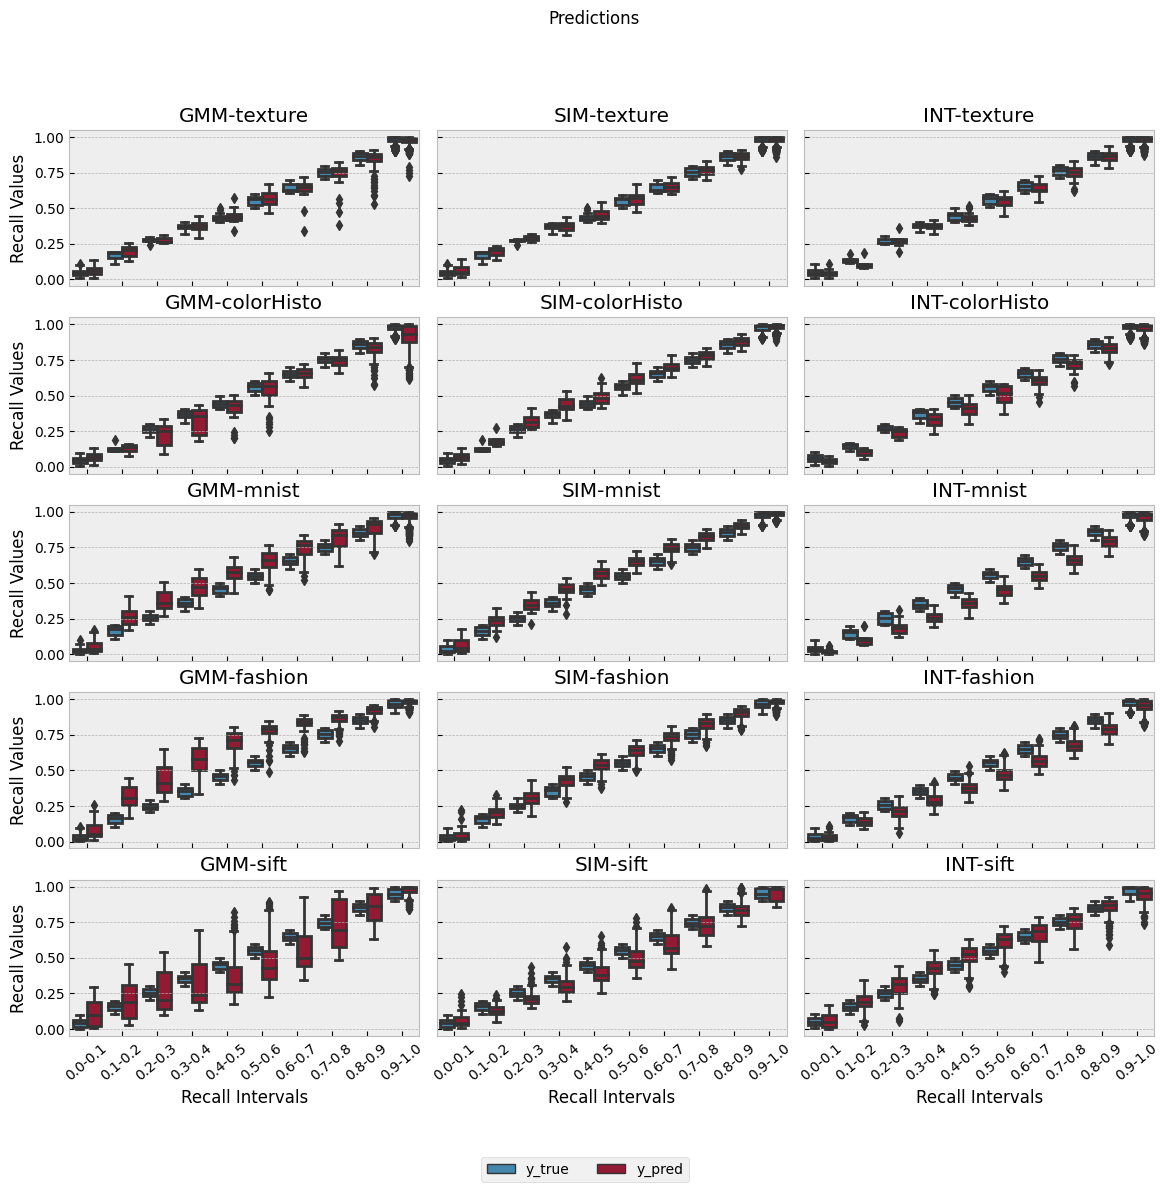

In [49]:
tmp_ = predictions[predictions.method.str.endswith('int')].copy()

fig, axes = plt.subplots(5,3,figsize=(14,12), dpi=100, sharey=True, sharex=True)
axes = iter(axes.reshape(-1))

l_gambeta = []
for b in ['texture', 'colorHisto', 'mnist', 'fashion', 'sift']:
    ''' gmm '''
    tmp = tmp_[(tmp_.base==b) & (tmp_.method=='gmm_int')].copy()
    labels = ['{}-{}'.format(np.round(i,1), np.round(i+0.1,1)) for i in np.arange(0,1,0.1)]
    tmp['Recall'] = pd.cut(tmp.y_true, bins=10, labels=labels)
    out = tmp.melt(id_vars='Recall', value_vars=['y_true', 'y_pred'])

    ax = next(axes)
    l_gambeta.append(ax)
    g = sns.boxplot(x='Recall', y='value', hue='variable', data=out, ax=ax)
    ax.set_title(f'GMM-{b}')
    ax.get_legend().remove()
    ax.set_xticklabels(g.get_xticklabels(), rotation=40)

    ''' similarity '''
    tmp = tmp_[(tmp_.base==b) & (tmp_.method=='sim_int')].copy()
    labels = ['{}-{}'.format(np.round(i,1), np.round(i+0.1,1)) for i in np.arange(0,1,0.1)]
    tmp['Recall'] = pd.cut(tmp.y_true, bins=10, labels=labels)
    out = tmp.melt(id_vars='Recall', value_vars=['y_true', 'y_pred'])

    ax = next(axes)
    l_gambeta.append(ax)
    g = sns.boxplot(x='Recall', y='value', hue='variable', data=out, ax=ax)
    ax.set_title(f'SIM-{b}')
    ax.get_legend().remove()
    ax.set_xticklabels(g.get_xticklabels(), rotation=40)

    ''' ifms '''
    tmp = tmp_[(tmp_.base==b) & (tmp_.method=='int')].copy()
    labels = ['{}-{}'.format(np.round(i,1), np.round(i+0.1,1)) for i in np.arange(0,1,0.1)]
    tmp['Recall'] = pd.cut(tmp.y_true, bins=10, labels=labels)
    out = tmp.melt(id_vars='Recall', value_vars=['y_true', 'y_pred'])

    ax = next(axes)
    l_gambeta.append(ax)
    g = sns.boxplot(x='Recall', y='value', hue='variable', data=out, ax=ax)
    ax.set_title(f'INT-{b}')
    ax.get_legend().remove()
    ax.set_xticklabels(g.get_xticklabels(), rotation=40)


l_gambeta = np.array(l_gambeta).reshape(5,3)
plt.setp(l_gambeta[-1, :], xlabel='Recall Intervals')
plt.setp(l_gambeta[:, 0], ylabel='Recall Values')
plt.setp(l_gambeta[:-1, :], xlabel='')
plt.setp(l_gambeta[:, 1:], ylabel='')

plt.suptitle('Predictions')
plt.subplots_adjust(wspace=0.05, hspace=0.2)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2)

## Concating GS results

In [137]:
gs_nn = [5, 55, 100, 150]
gs_R = [1, 10, 40, 120]
gs = predictions[(predictions.NN.isin(gs_nn)) & (predictions.R.isin(gs_R)) & (predictions.method=='gmm_orig')].copy()
gs.method = 'gs'
preds = predictions.copy()
preds = pd.concat([preds, gs])

## Evaluating recommendations

In [181]:
# optimizing memory
from itertools import product
from sklearn.metrics import mean_squared_error

recommendations = pd.DataFrame()
prods = product(preds.base.unique(), np.append(preds.method.unique(), 'optimal'))
for b, m in prods:
    recall = 'y_true' if m in ['gs', 'optimal'] else 'y_pred'
    if m == 'optimal':
        rec = preds[
            (preds.base == b) &
            (preds.method == 'gmm_orig') &
            (preds['y_true'] >= 0.9)
        ].sort_values(by=['NN', 'R']).iloc[0, :]
        rec.method = 'optimal'
    else:
        tmp = preds[(preds.base == b) & (preds.method == m)].copy()
        y_true = tmp.y_true
        y_pred = tmp.y_pred
        mse = mean_squared_error(y_true, y_pred) # ** (1/2)
        tmp.y_pred -= mse
        rec = tmp[(tmp[recall] >= 0.9)].sort_values(by=['NN', 'R']).iloc[0, :]
    recommendations = pd.concat([recommendations, rec.to_frame().T])


<AxesSubplot:xlabel='base', ylabel='NN'>

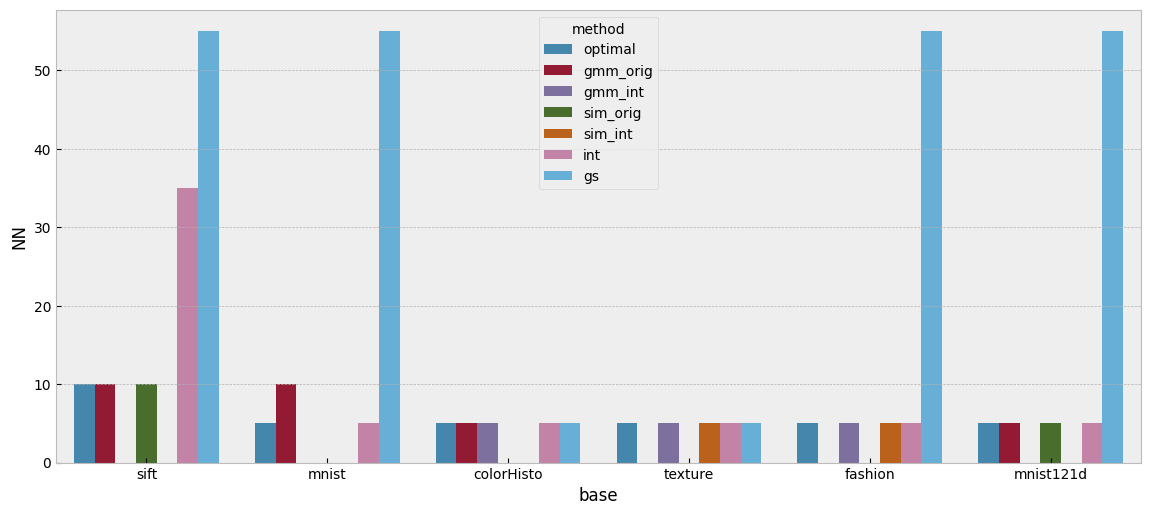

In [182]:
hue_order = ['optimal', 'gmm_orig', 'gmm_int', 'sim_orig', 'sim_int', 'int', 'gs']
plt.figure(figsize=(14, 6), dpi=100)
sns.barplot(x='base', y='NN', hue='method', hue_order=hue_order, data=recommendations[recommendations.y_true >= 0.90])

In [211]:
pd.set_option("display.max_columns", 101)
pd.set_option("display.max_rows", 201)

tmp = preds[(preds.method.str.startswith('gmm')) & (preds.base == 'sift')].copy()
nn = tmp[tmp.method == 'gmm_orig'].NN.unique()
r = tmp[tmp.method == 'gmm_orig'].R.unique()
tmp = tmp[(tmp.NN.isin(nn)) & tmp.R.isin(r)]
tmp = tmp[tmp.R != 200]
tmp.sort_values(by=['NN', 'R', 'graph_type', 'method'])

,base,y_true,y_pred,target,NN,R,graph_type,method,k_searching
168,sift,0.016667,0.079165,Recall,5.0,1.0,0.0,gmm_int,30.0
71,sift,0.016667,0.050797,Recall,5.0,1.0,0.0,gmm_orig,30.0
314,sift,0.004333,0.004837,Recall,5.0,1.0,1.0,gmm_int,30.0
7,sift,0.004333,0.004316,Recall,5.0,1.0,1.0,gmm_orig,30.0
534,sift,0.001000,0.006025,Recall,5.0,1.0,2.0,gmm_int,30.0
55,sift,0.001000,0.004822,Recall,5.0,1.0,2.0,gmm_orig,30.0
663,sift,0.104667,0.306863,Recall,5.0,5.0,0.0,gmm_int,30.0
4,sift,0.104667,0.331934,Recall,5.0,5.0,0.0,gmm_orig,30.0
878,sift,0.005000,0.015824,Recall,5.0,5.0,1.0,gmm_int,30.0
34,sift,0.005000,0.032318,Recall,5.0,5.0,1.0,gmm_orig,30.0
